# 01. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings

warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

# 02. Import Data

In [2]:
# Folder Path
path = r'C:\Users\jrper\OneDrive\Documents\Career Foundry Data Analytics Program\Achievement 6'

In [3]:
# Import trips_wrangled_no_outliers2.csv
df_trips = pd.read_csv(os.path.join(path, '02 Data', 'Prepared Data', 'trips_wrangled_no_outliers2.csv'), index_col = False)

# 03. Explore Data

In [4]:
# View first 5 rows for df_trips
df_trips.head()

,Unnamed: 0,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,...,weekday_stoptime,month_name_starttime,month_name_stoptime,hour_starttime,hour_stoptime,customer_age,starttime_counts,tripduration_minutes,tripduration_hours,tripduration_buckets
0,0,226,2020-01-01 00:04:50.192,2020-01-01 00:08:37.037,3186,Grove St PATH,40.719586,-74.043117,3211,Newark Ave,...,Wednesday,January,January,0,0,36,25629,3.766667,0.062778,10 minutes or less
1,1,377,2020-01-01 00:16:01.670,2020-01-01 00:22:19.080,3186,Grove St PATH,40.719586,-74.043117,3269,Brunswick & 6th,...,Wednesday,January,January,0,0,31,25629,6.283333,0.104722,10 minutes or less
2,2,288,2020-01-01 00:17:33.877,2020-01-01 00:22:22.442,3186,Grove St PATH,40.719586,-74.043117,3269,Brunswick & 6th,...,Wednesday,January,January,0,0,31,25629,4.800000,0.080000,10 minutes or less
3,3,435,2020-01-01 00:32:05.902,2020-01-01 00:39:21.066,3195,Sip Ave,40.730897,-74.063913,3280,Astor Place,...,Wednesday,January,January,0,0,51,15767,7.250000,0.120833,10 minutes or less
4,4,231,2020-01-01 00:46:19.678,2020-01-01 00:50:11.344,3186,Grove St PATH,40.719586,-74.043117,3276,Marin Light Rail,...,Wednesday,January,January,0,0,37,25629,3.850000,0.064167,10 minutes or less


In [5]:
# Drop 'Unnamed: 0' column
df_trips.drop(columns = ['Unnamed: 0'], inplace = True)

In [6]:
# View df_trips row and column count
df_trips.shape

(379861, 32)

In [7]:
# Convert 'starttime' and 'stoptime' columns to datetime instead of object
df_trips['starttime'] = pd.to_datetime(df_trips['starttime'])
df_trips['stoptime'] = pd.to_datetime(df_trips['stoptime'])

In [8]:
# View df_trips column datatypes
df_trips.dtypes

tripduration                        int64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start station id                    int64
start station name                 object
start station latitude            float64
start station longitude           float64
end station id                      int64
end station name                   object
end station latitude              float64
end station longitude             float64
bikeid                              int64
usertype                           object
birth year                          int64
gender                             object
day_of_month_starttime              int64
month_starttime                     int64
year_starttime                      int64
day_of_month_stoptime               int64
month_stoptime                      int64
year_stoptime                       int64
weekday_starttime                  object
weekday_stoptime                   object
month_name_starttime              

# 04. Time Series Analysis

## Prepare Data for Time Series Analysis

In [9]:
# Extract date from datetime column
df_trips['starttime_date'] = df_trips['starttime'].dt.date

In [10]:
# View new 'starttime_date' column
df_trips['starttime_date'].head()

0    2020-01-01
1    2020-01-01
2    2020-01-01
3    2020-01-01
4    2020-01-01
Name: starttime_date, dtype: object

In [11]:
# Check datatype for 'starttime_date' column
df_trips['starttime_date'].dtype

dtype('O')

#### Observations: Datatype will need to be changed to datetime for time series analysis.

In [12]:
# Create dataframe for time series analysis by aggregating 'starttime_date' counts, rename new column for clarity, and reset index.
data = df_trips.groupby(['starttime_date']).agg({'starttime_date': 'count'}).rename(columns={'starttime_date':'startdate_counts'}).reset_index()

In [13]:
# Ensure new dataframe was successfully created.
data

,starttime_date,startdate_counts
0,2020-01-01,370
1,2020-01-02,892
2,2020-01-03,772
3,2020-01-04,566
4,2020-01-05,501
...,...,...
480,2021-04-26,759
481,2021-04-27,888
482,2021-04-28,1190
483,2021-04-29,841


In [14]:
from datetime import datetime

# Create datetime column from 'starttime_date'
data['startdate'] = pd.to_datetime(data['starttime_date'])

# Set datetime as the index of dataframe.
data = data.set_index('startdate') 

# Drop 'starttime_date' column
data.drop(['starttime_date'], axis=1, inplace=True)

# View new dataframe
data.head()

,startdate_counts
startdate,
2020-01-01,370
2020-01-02,892
2020-01-03,772
2020-01-04,566
2020-01-05,501


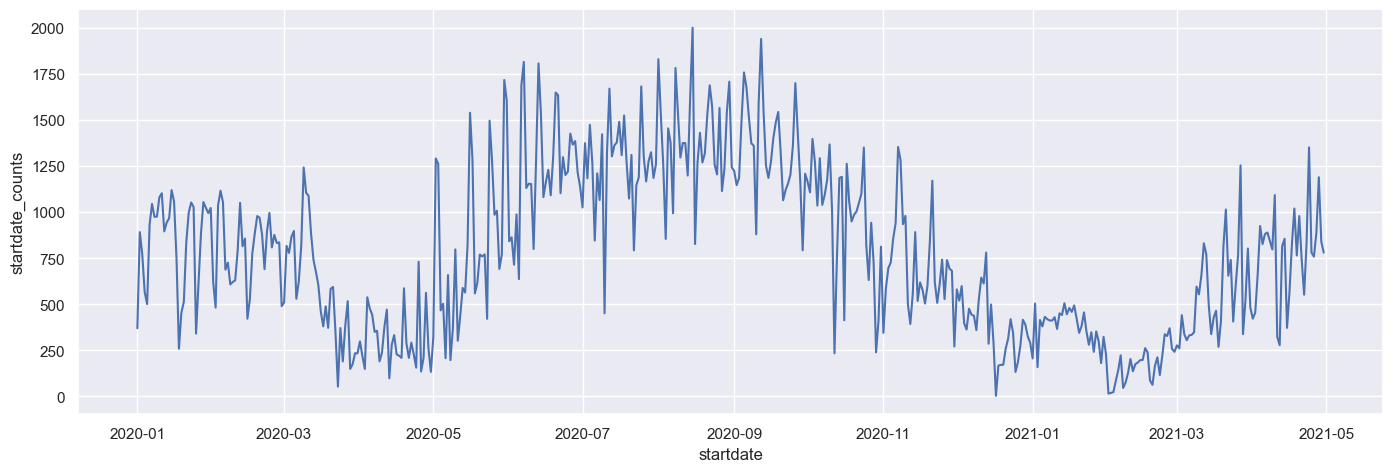

In [15]:
# Plot new data set

sns.set(rc={'figure.figsize':(15, 5)})
sns.lineplot(
    x ='startdate',
    y ='startdate_counts',
    data = data )
plt.show()

#### Observations: Because the data was collected daily, there is significant fluctuation and noise. The moving average for 7 days (1 week) will be calculated to smooth data and make trends more visible.

In [16]:
# Calculate moving average as smoothing technique. 
data['mov_avg'] = data['startdate_counts'].rolling(7).sum()

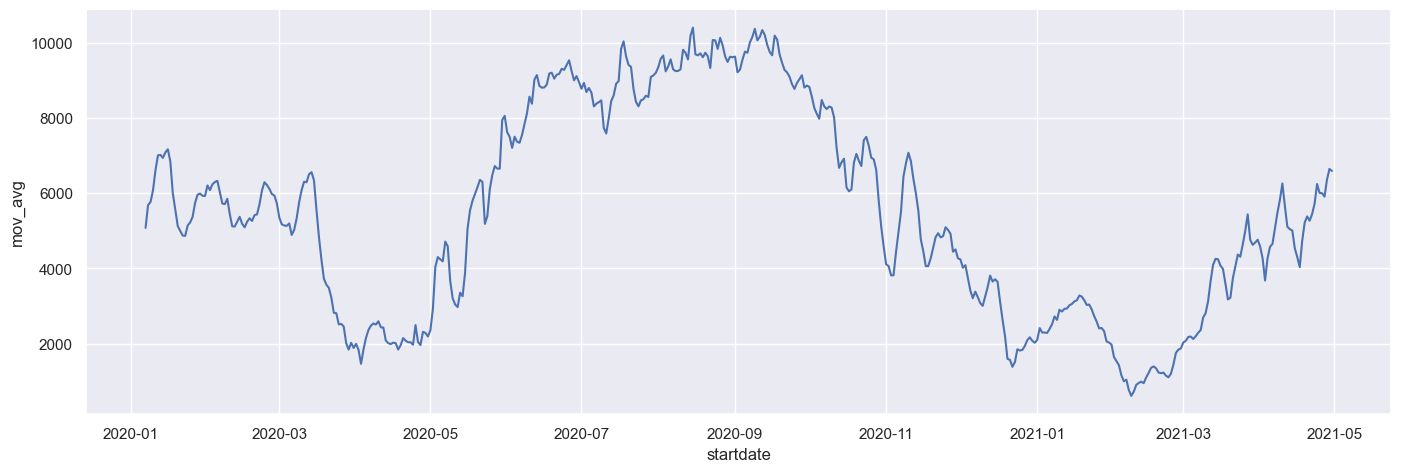

In [17]:
# Plot data using moving average

sns.set(rc={'figure.figsize':(15, 5)})
sns.lineplot(
    x ='startdate',
    y ='mov_avg',
    data = data )
plt.show()

#### Observations: There is significantly less fluctuation and noise. 

## Decomposition

In [18]:
# Specify frequency for decomposition model. Data is daily, or 'd'.
data = data.asfreq('d')

In [19]:
# Check for missing values
data.isnull().sum() 

startdate_counts    1
mov_avg             7
dtype: int64

#### Observations: There is one missing value for 'startdate_counts' after defining frequency, and 7 for 'mov_avg' for the first 7 rows. Fill in using 'bfill', 'ffill' for decomposition.

In [20]:
# Fill in missing value 
data = data.fillna(method='bfill').fillna(method='ffill')

In [21]:
# Ensure missing value has been resolved.
data.isnull().sum()

startdate_counts    0
mov_avg             0
dtype: int64

#### There are no more missing values.

In [22]:
# Decompose time series using an additive model
decomposition = sm.tsa.seasonal_decompose(data['mov_avg'], model='additive')

In [23]:
# Define fixed size for all special charts.

from pylab import rcParams
rcParams['figure.figsize'] = 18, 7

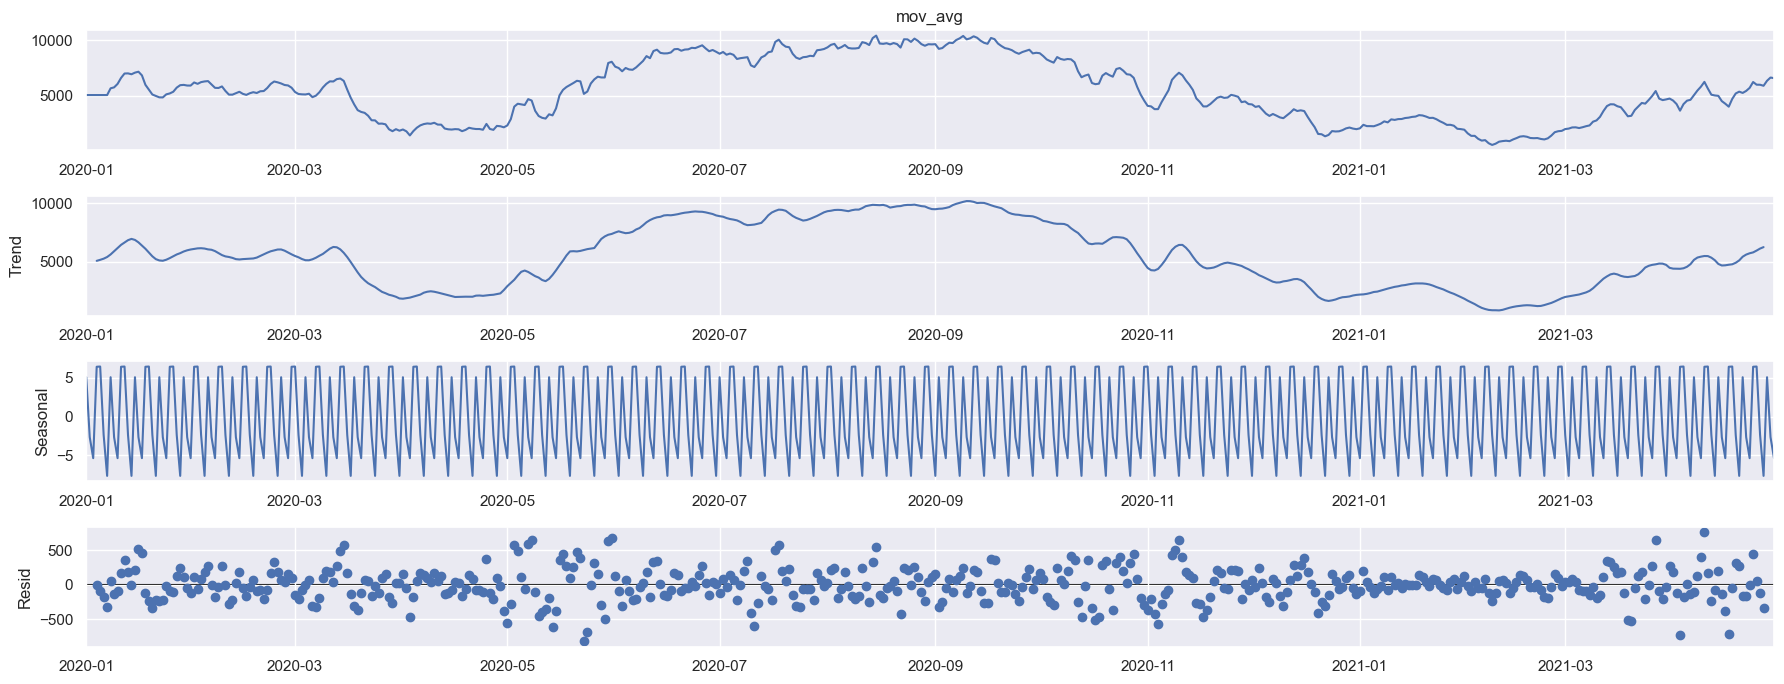

In [24]:
# Plot separate components
decomposition.plot()
plt.show()

#### Observations: There is seasonality with a larger number of trips in the summer and a decrease in trips taken during the winter. The decrease during the spring of 2020 is likely due to the Covid-19 quarantine. There is also a significant residual, or unexplained noise.  

## Test for Stationarity

In [25]:
# Import adfuller() function
from statsmodels.tsa.stattools import adfuller 

# Define function

def dickey_fuller(timeseries): 
    # Perform the Dickey-Fuller test:
    
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply test using function on time series
dickey_fuller(data['mov_avg'])

Dickey-Fuller Stationarity test:
Test Statistic                  -1.431290
p-value                          0.567187
Number of Lags Used             15.000000
Number of Observations Used    470.000000
Critical Value (1%)             -3.444340
Critical Value (5%)             -2.867709
Critical Value (10%)            -2.570056
dtype: float64


#### Observations: 
#### Null Hypothesis: A unit root is present.
#### Alternative Hypothesis: A unit root is not present.
#### The test statistic is larger than all of the critical values, so the null hypothesis cannot be rejected and the data is non-stationary.
#### The p-value is much larger than 0.05 which does not indicate a significant test result.

## Stationarize Data

In [26]:
# Differencing: The df.shift(1) function turns observation to t-1
data_diff = data - data.shift(1) 

In [27]:
# Remove missing values from differencing for Dickey-Fuller test.
data_diff.dropna(inplace = True) 

In [28]:
# View data_diff
data_diff.head()

,startdate_counts,mov_avg
startdate,,
2020-01-02,522.0,0.0
2020-01-03,-120.0,0.0
2020-01-04,-206.0,0.0
2020-01-05,-65.0,0.0
2020-01-06,431.0,0.0


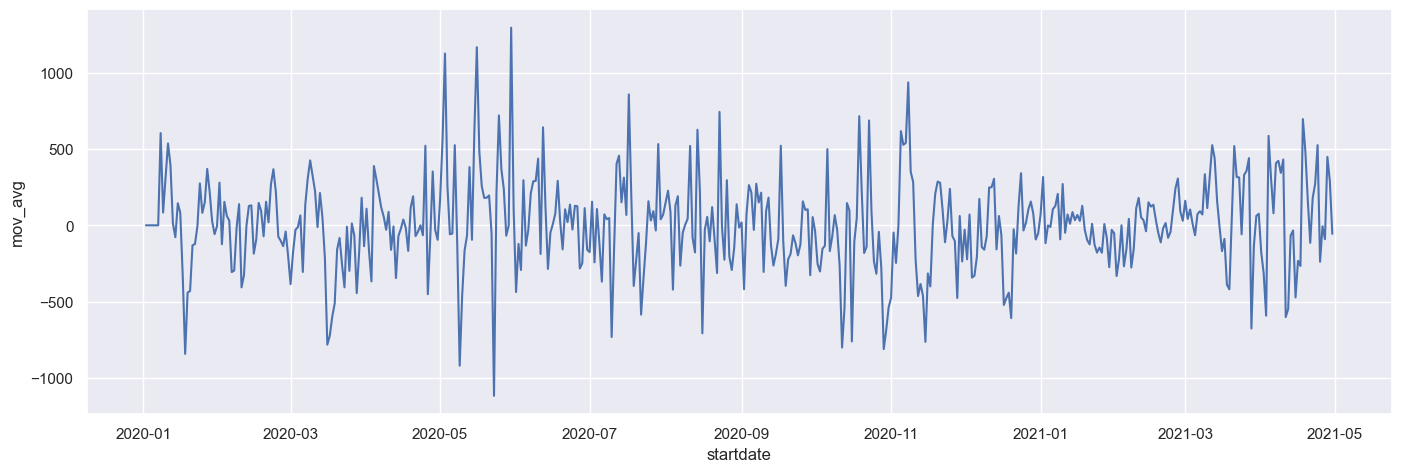

In [29]:
# Plot data_diff

sns.set(rc={'figure.figsize':(15, 5)})
sns.lineplot(
    x ='startdate',
    y ='mov_avg',
    data = data_diff )
plt.show()

In [30]:
# Dickey Fuller test for data_diff
dickey_fuller(data_diff['mov_avg'])

Dickey-Fuller Stationarity test:
Test Statistic                  -3.287486
p-value                          0.015447
Number of Lags Used             18.000000
Number of Observations Used    466.000000
Critical Value (1%)             -3.444461
Critical Value (5%)             -2.867762
Critical Value (10%)            -2.570084
dtype: float64


#### Observations: The test statistic is now smaller than the 5% and 10% critical values, so the null hypothesis can be rejected with 95% confidence and the data is now stationary. The p-value is less than 0.05 which indicates a significant test result.

## Check Autocorrelations

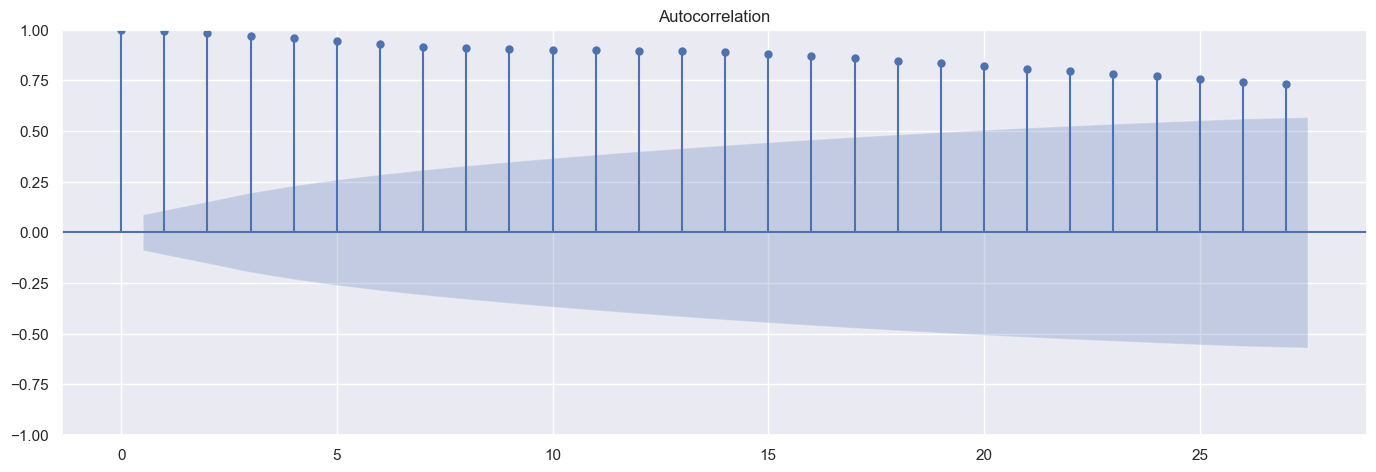

In [31]:
# Import autocorrelation and partial correlation plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

# Plot autocorrelations before differencing
plot_acf(data['mov_avg'])
plt.show()

#### Observations: There are many lags (28) beyond the confidence interval which shows that the data is non-stationary.

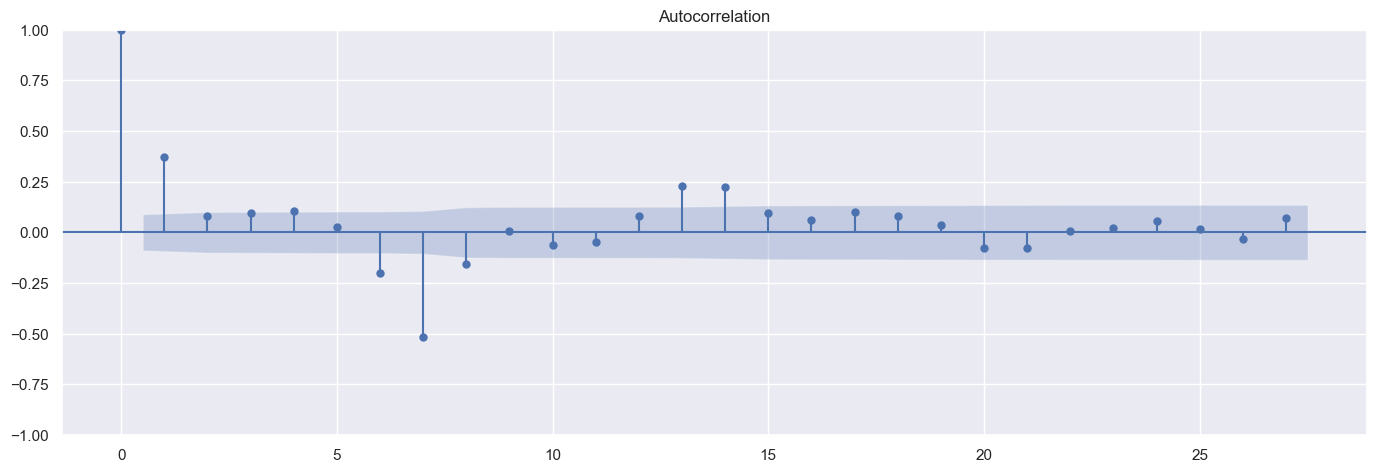

In [32]:
# Plot autocorrelations after differencing
plot_acf(data_diff['mov_avg'])
plt.show()

#### Observations: After differencing, there are only 9 lags beyond the confidence interval which suggests weak stationarity. Because there are fewer than 10 significant lags, another round of differencing will not be required. 